# Digital Demodulation of RAW signal

All the notation & argument naming follows Blais review paper

$$
\begin{align}
\hat{V}_{I}(t) & = V_{\text{IF}}\Big[ \hat{X}_{f}(t)\cos(\omega_{\text{IF}}t)-\hat{P_{f}}(t)\sin(\omega_{\text{IF}}t)\Big] + \hat{V}_{\text{noise},t}(t) \\ \\
\hat{V}_{Q}(t) & = -V_{\text{IF}}\Big[ \hat{P}_{f}(t)\cos(\omega_{\text{IF}}t)+\hat{X_{f}}(t)\sin(\omega_{\text{IF}}t)\Big] + \hat{V}_{\text{noise},t}(t)

\end{align}
$$

$$
\begin{equation}
\hat{X}_f = \frac{\hat{a}^\dagger_f + \hat{a}_f}{2}, 
\quad 
\hat{P}_f = \frac{i(\hat{a}^\dagger_f - \hat{a}_f)}{2},
\end{equation}
$$

$$
\begin{bmatrix}
X_{f}(t) \\
P_{f}(t)
\end{bmatrix}
= R^{-1}(t)
\begin{bmatrix}
V_{I}(t) \\
V_{Q}(t)
\end{bmatrix} 

$$

In [1]:
import numpy as np 
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup




descriptor = generate_descriptor(
    #pqsc=[""], # 장비 여러개 사용시
    shfqc_6=["DEV12256"],
    number_data_qubits=6,
    multiplex=True,
    number_multiplex=6,
    include_cr_lines=True,
    include_ef_lines=True,
    get_zsync=False,  # Only set to True when using real device
    save = True,
    filename="TG_RIP",
    ip_address="192.168.0.83"
)


#descriptor
setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments

In [2]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=False)
#session.disconnect()

[2025.12.31 14:08:43.007] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /home/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2025.12.31 14:08:43.008] INFO    VERSION: laboneq 25.10.2
[2025.12.31 14:08:43.009] INFO    Connecting to data server at 192.168.0.83:8004
[2025.12.31 14:08:43.059] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2025.12.31 14:08:43.101] INFO    Configuring the device setup
[2025.12.31 14:08:43.130] INFO    The device setup is configured


In [3]:
from qpu_types import TransmonQubit, TransmonQubitParameters
from helper import load_qubit_parameters, save_qubit_parameters
from operations import TransmonOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform



_loaded_qubits = load_qubit_parameters(filename="latest") 
#qubits = TransmonQubit.from_device_setup(setup) # Also can be done with load_qubit_parameters 
qubits = list(_loaded_qubits.values())





qpu = QPU(quantum_elements=qubits, quantum_operations=TransmonOperations())
#quantum_platform = QuantumPlatform(setup=setup, qpu=qpu)

# qpu.topology.add_edge("bus", "q16", "q17")
# qpu.topology.add_edge("bus", "q17", "q18")
# qpu.topology.add_edge("bus", "q18", "q19")
# qpu.topology.plot()




from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store") 
folder_store.activate()
#folder_store.deactivate()
#workflow.logbook.LoggingStore().activate()
#workflow.logbook.LogbookStore().deactivate()


LOADED:./qubit_parameters/20251231-1406_sample2.json


# Resonator Spectroscopy

In [ ]:
from experiments import resonator_spectroscopy

####################################################################################
q=qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
#temp_pars.readout_resonator_frequency = 7.6283e9 #6.04036e9 #mode1
# temp_pars.readout_range_out = - 10
# temp_pars.readout_amplitude = 0.3
# temp_pars.reset_delay_length =200e-6
#temp_pars.readout_lo_frequency = 5.6e9
temporary_parameters[q.uid] = temp_pars
print(q.readout_parameters())
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#frequencies = q.parameters.readout_resonator_frequency + np.linspace(-10e6,10e6,501)
frequencies = temp_pars.readout_resonator_frequency + np.linspace(-2.0e6,2.0e6,1001)
#####################################################################################
options = resonator_spectroscopy.experiment_workflow.options()
#workflow.show_fields(options)
options.count(1024)
options.update(False)
options.use_cw(False) #qop.measure 
#options.fit_complex_resonator(False)
options.fit_lorentzian(True)
######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow
res_spec = resonator_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=frequencies,
    options=options,
    temporary_parameters=temporary_parameters
)
res_spec_result = res_spec.run()
res_spec_analysis_result = res_spec_result.tasks["analysis_workflow"]
pprint(res_spec_analysis_result.output)

In [ ]:
from experiments import qubit_spectroscopy

###############################################################
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.spectroscopy_amplitude = 0.006 #0.003
temporary_parameters[q.uid] = temp_pars

#q.parameters.readout_amplitude = 1.0
frequencies = q.parameters.resonance_frequency_ge+ np.linspace(-2e6, 2e6, 401)
#print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
pprint(q.spectroscopy_parameters())
################################################################
options = qubit_spectroscopy.experiment_workflow.options()
options.update(False)
options.count(1024)
# workflow.show_fields(options)
###################################################################
qubit_spec = qubit_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    frequencies=frequencies,
    options=options,
    temporary_parameters=temporary_parameters
)

qubit_spec_result = qubit_spec.run()
qubit_spec_result

# Dispersive Shift

In [36]:
from experiments import dispersive_shift

#######################################################################
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.readout_integration_delay = 320e-9
temp_pars.readout_integration_length = 500e-9
temp_pars.readout_range_out = 0
temp_pars.readout_amplitude = 0.5
temp_pars.readout_length = 1.0e-6
temp_pars.readout_resonator_frequency = 7.5582e9
temporary_parameters[q.uid] = temp_pars

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = dispersive_shift.experiment_workflow.options()
options.count(1024)
options.update(False)
#print(workflow.show_fields(options))

###################################################################
dispersive = dispersive_shift.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=q.parameters.readout_resonator_frequency + np.linspace(-5e6,5e6,201),
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)

dispersive_result = dispersive.run() 
print(dispersive_result.tasks['analysis_workflow'].output)

DRIVE range (dBm) : 10, READOUT range (dBm) : 0
[2025.12.31 14:24:45.933] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.12.31 14:24:45.933] INFO      Workflow 'dispersive_shift': execution started at 2025-12-31                  
[2025.12.31 14:24:45.934] INFO      05:24:45.932931Z                                                              
[2025.12.31 14:24:45.935] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.12.31 14:24:45.945] INFO    Task 'temporary_qpu': started at 2025-12-31 05:24:45.944928Z
[2025.12.31 14:24:45.946] INFO    Task 'temporary_qpu': ended at 2025-12-31 05:24:45.946064Z
[2025.12.31 14:24:45.948] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-12-31 
[2025.12.31 14:24:45.949] INFO    05:24:45.948547Z
[2025.12.31 14:24:45.949] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-12-31 05:24:45.949342Z
[2025.12.31 14:24:45.950] INFO    Tas

# Params

# IQ Blobs

AcquisitionType : INTEGRATION 
AveragingMode : SINGLESHOT

In [43]:
qubits[0].parameters.readout_integration_delay = 320e-9
qubits[0].parameters.readout_integration_length = 800e-9
qubits[0].parameters.readout_range_out = 0
qubits[0].parameters.readout_resonator_frequency = 7.5579e9
qubits[0].parameters.readout_amplitude = 0.5
qubits[0].parameters.readout_length = 1.0e-6


In [42]:

from experiments import iq_blobs

#######################################################################
q = qubits[0]

temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.readout_integration_delay = 320e-9
temp_pars.readout_integration_length = 800e-9
temp_pars.readout_range_out = 0
temp_pars.readout_amplitude = 0.5
temp_pars.readout_length = 1.0e-6
temp_pars.readout_resonator_frequency = 7.5579e9
temporary_parameters[q.uid] = temp_pars
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = iq_blobs.experiment_workflow.options()
options.count(2**14)
#print(workflow.show_fields(options))

###################################################################
iq = iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)
iq_blob_result = iq.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
iq_blob_result.tasks['analysis_workflow'].tasks['plot_iq_blobs'].output[q.uid]
print(iq_blob_result.tasks['analysis_workflow'].output)


DRIVE range (dBm) : 10, READOUT range (dBm) : 0
[2025.12.31 14:27:42.508] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.12.31 14:27:42.508] INFO      Workflow 'iq_blobs': execution started at 2025-12-31 05:27:42.507901Z         
[2025.12.31 14:27:42.508] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.12.31 14:27:42.515] INFO    Task 'temporary_qpu': started at 2025-12-31 05:27:42.515707Z
[2025.12.31 14:27:42.516] INFO    Task 'temporary_qpu': ended at 2025-12-31 05:27:42.516853Z
[2025.12.31 14:27:42.518] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-12-31 
[2025.12.31 14:27:42.519] INFO    05:27:42.518672Z
[2025.12.31 14:27:42.519] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-12-31 05:27:42.519446Z
[2025.12.31 14:27:42.520] INFO    Task 'create_experiment': started at 2025-12-31 05:27:42.520083Z
[2025.12.31 14:27:42.524] INFO    Task 'create_experi

In [ ]:
iq_blob_result

In [ ]:
# from laboneq.simple import show_pulse_sheet
# from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# show_pulse_sheet(compiled_experiment=iq_blob_result.tasks["compile_experiment"].output,name='test', interactive=True, max_events_to_publish=10000)


# IQ Traj



To plot trajectory 
AcquisitionType : RAW   
AveragingMode : cyclic



#### Readout Pulse Shaping

rise and fall time $\tau_r$  
- $\tau_r \gg 1/\kappa$  $\implies$ adiabatic  
- $\tau_r \le 1/\kappa$  $\implies$ non-adiabatic

일반적인 steady state discrimination 이 목표라면 $\tau_r \approx 3 \sim 5 /\kappa$  


의도적으로 non-adiabatic regime 에서 fast readout도 가능

In [ ]:
# qubits[0].parameters.readout_integration_length = 0.8e-6
# qubits[0].parameters.readout_length = 1.0e-6


In [ ]:
qubits[1].parameters.readout_integration_delay
qubits[1].parameters.readout_integration_length

In [9]:
qubits[0].parameters.readout_range_out = 0

DRIVE range (dBm) : 10, READOUT range (dBm) : 0
('measure',
 {'amplitude': 0.7,
  'length': 2e-06,
  'pulse': {'function': 'GaussianSquare',
            'risefall_sigma_ratio': 3.0,
            'sigma': 0.2}})
[2025.12.31 14:26:39.243] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.12.31 14:26:39.243] INFO      Workflow 'iq_traj': execution started at 2025-12-31 05:26:39.242842Z          
[2025.12.31 14:26:39.243] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.12.31 14:26:39.250] INFO    Task 'temporary_qpu': started at 2025-12-31 05:26:39.250620Z
[2025.12.31 14:26:39.251] INFO    Task 'temporary_qpu': ended at 2025-12-31 05:26:39.251669Z
[2025.12.31 14:26:39.253] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-12-31 
[2025.12.31 14:26:39.254] INFO    05:26:39.253814Z
[2025.12.31 14:26:39.254] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-12-31 05:26:3

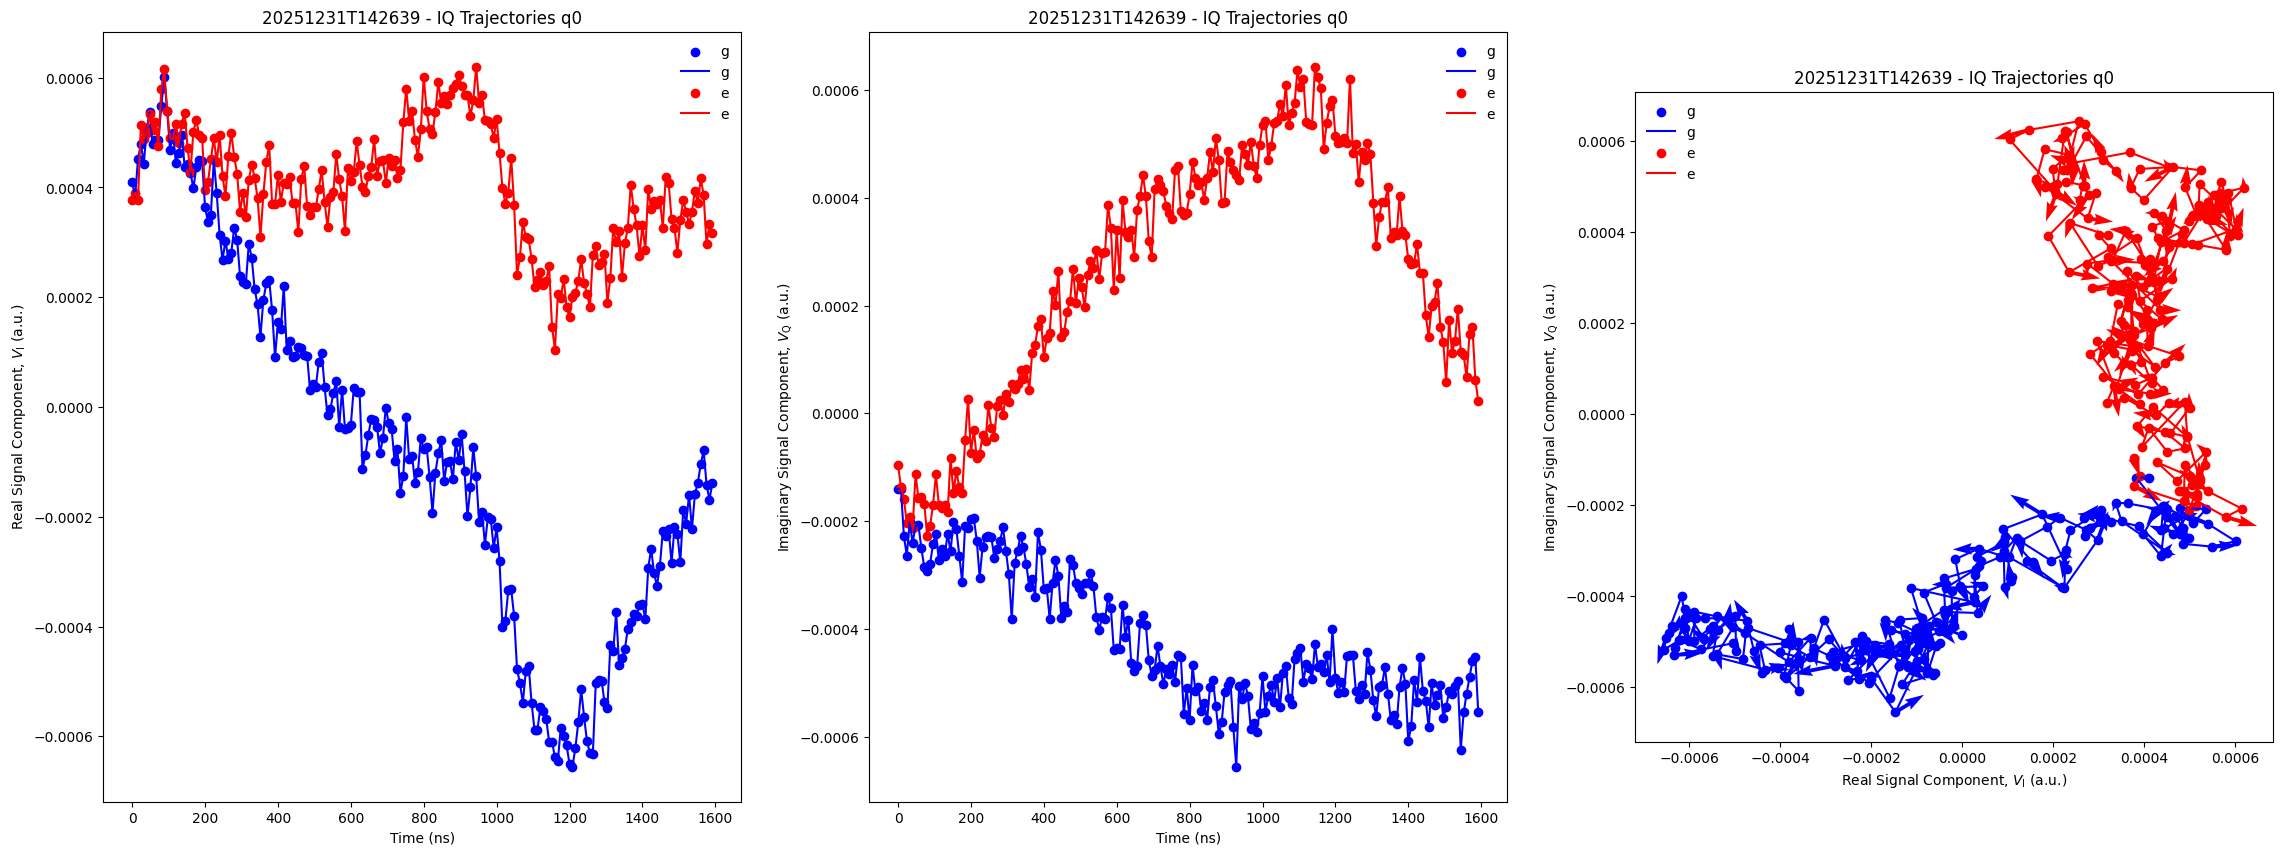

In [40]:
from experiments import iq_traj

####################################################################################
q=qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars.readout_resonator_frequency = 7.6270e9
temp_pars.readout_integration_delay = 320e-9
temp_pars.readout_integration_length = 800e-9
temp_pars.readout_range_out = 0
temp_pars.readout_amplitude = 0.5
temp_pars.readout_length = 1.0e-6
temp_pars.readout_resonator_frequency = 7.5579e9
# temp_pars.readout_range_out = -10
temporary_parameters[q.uid] = temp_pars
#######################################################################
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
#######################################################################
options = iq_traj.experiment_workflow.options()
options.count(2**14)
options.do_analysis(True)


#print(workflow.show_fields(options))

###################################################################
iq_t = iq_traj.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)

iq_traj_result = iq_t.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
iq_traj_result.tasks['analysis_workflow'].tasks['plot_iq_trajectories'].output[q.uid]

#### SAVING DATA


In [ ]:
# from laboneq.simple import save, load


# #save(obj=iq_traj_result.output, filename='traj_test')

# RDATA = load(filename='traj_test')


- For $2\mu s$ acquire we have  2000ns/0.5ns=4000 sample

# Time Trace

In [ ]:
qubits[0].readout_parameters()

In [ ]:
from laboneq_applications.experiments import time_traces

q=qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
# temp_pars.readout_amplitude = 0.4
# temp_pars.drive_lo_frequency = 4.6e9
# temp_pars.readout_length = 0.8e-6
# temp_pars.readout_integration_length=1e-6
temporary_parameters[q.uid] = temp_pars
#######################################################################
pprint(q.readout_parameters())
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")

cf = 50e6
#######################################################################
options = time_traces.experiment_workflow.options()
options.update(False)
options.filter_kernels(True)
options.filter_cutoff_frequency(cf)
options.granularity(1)

#print(workflow.show_fields(options))

###################################################################
raw_trace = time_traces.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)

raw_trace_result = raw_trace.run()
raw_trace_analysis_result = raw_trace_result.tasks['analysis_workflow'].output
print(raw_trace_analysis_result)

In [ ]:
# from laboneq.simple import show_pulse_sheet
# from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# show_pulse_sheet(compiled_experiment=raw_trace_result.tasks["compile_experiment"].output,name='test', interactive=True)
# plot_simulation(compiled_experiment=raw_trace_result.tasks["compile_experiment"].output)

In [ ]:
import matplotlib.pyplot as plt
tr_t=raw_trace_result.tasks['analysis_workflow'].tasks['truncate_time_traces'].output
#raw_trace_result.tasks['analysis_workflow'].tasks['extract_kernels_thresholds'].output

r=tr_t["q2"]


plt.plot(r[2])

In [ ]:
import scipy as sp
krn=kernels
sos = sp.signal.butter(N=10, Wn=90e6,btype="lowpass", fs=2e9,output="sos")
fkrn=sp.signal.sosfiltfilt(sos, krn)

plt.plot(fkrn.real)
plt.plot(fkrn.imag)
# from analysis import time_traces
# time_traces.filter_integration_kernels(qubits=)



In [ ]:
raw_trace_result.tasks['analysis_workflow'].tasks["plot_kernels_fft"].output['q2']

In [ ]:
from laboneq_applications.analysis import time_traces
e_raw = raw_trace_result.output.data['q2']['result/e'].data
g_raw = raw_trace_result.output.data['q2']['result/g'].data

# Save Qubit Parameters

In [44]:
from helper import load_qubit_parameters, save_qubit_parameters
save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters", filename="sample2")

Qubit parameters stored as JSON in /home/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/qubit_parameters/20251231-1430_sample2.json
